In [1]:
!pip install xgboost mord --quiet

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from mord import OrdinalRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau


In [2]:
# Load
train_df     = pd.read_csv("f1_2022_2023_train.csv" )
test_2024_df = pd.read_csv("f1_2024_test.csv")
pred_2025_df = pd.read_csv("f1_2025_pred.csv" )

print("2022–2023:", train_df.shape)
print("2024     :", test_2024_df.shape)
print("2025     :", pred_2025_df.shape)

2022–2023: (538, 59)
2024     : (479, 59)
2025     : (438, 55)


In [3]:
# Helper: race-level re-ranking (you already had this idea)
def rerank_within_race(df, pred_col, group_cols=None, ascending=True):
    if group_cols is None:
        group_cols = ["year", "race_name"]
    df = df.copy()
    df["final_predicted_rank"] = (
        df.groupby(group_cols)[pred_col]
          .rank(method="first", ascending=ascending)
          .astype(int)
    )
    return df

# Common metric function (unchanged)
def evaluate_regression_model(model_name, y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2   = r2_score(y_true, y_pred)
    spearman, _ = spearmanr(y_true, y_pred)
    kendall, _  = kendalltau(y_true, y_pred)

    abs_err = np.abs(y_true - y_pred)
    top1 = np.mean(abs_err <= 1)
    top2 = np.mean(abs_err <= 2)
    top3 = np.mean(abs_err <= 3)

    print(f"\n=== {model_name} ===")
    print(f"MAE:               {mae:.3f}")
    print(f"RMSE:              {rmse:.3f}")
    print(f"R²:                {r2:.3f}")
    print(f"Spearman rho:      {spearman:.3f}")
    print(f"Kendall tau:       {kendall:.3f}")
    print(f"Within 1 position: {top1:.3f}")
    print(f"Within 2 positions:{top2:.3f}")
    print(f"Within 3 positions:{top3:.3f}")

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Spearman": spearman,
        "Kendall": kendall,
        "Top1": top1,
        "Top2": top2,
        "Top3": top3
    }

# Small helper to build preprocessor + models for a given feature matrix
def build_preprocessor_and_models(X):
    categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
    numeric_cols     = X.select_dtypes(include=["number"]).columns.tolist()

    print("Categorical columns:", categorical_cols)
    print("Numeric columns (first 10):", numeric_cols[:10])

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )

    # Define models (same structure you had)
    linreg_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", LinearRegression())
    ])

    ridge_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", Ridge(alpha=1.0))
    ])

    lasso_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", Lasso(alpha=0.001, max_iter=20000))
    ])

    rf_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.7,
            colsample_bytree=0.7,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ])

    ord_model = Pipeline([
        ("preprocess", preprocessor),
        ("model", OrdinalRidge(alpha=1.0))
    ])

    models = {
        "Linear Regression": linreg_model,
        "Ridge Regression":  ridge_model,
        "Lasso Regression":  lasso_model,
        "Random Forest":     rf_model,
        "XGBoost":           xgb_model,
        "Ordinal Ridge":     ord_model
    }

    return preprocessor, models, categorical_cols, numeric_cols

## Finishing position model

In [10]:
# Stack 2022–2024 with labels
df_all = pd.concat([train_df, test_2024_df], axis=0).reset_index(drop=True)
df_all = df_all.sort_values(["year", "round"]).reset_index(drop=True)

target_col_pos = "finishing_position"

# Columns to drop from features
drop_cols = [target_col_pos]

# Avoid leakage from points
if "points" in df_all.columns:
    drop_cols.append("points")

# ID-like columns to drop (or other target columns)
id_like_cols = ["driverId", "raceId", "driver_code", "Driver.code", "race_name", 
                "round", "driver", 'flg_podium', 'flg_top5']
for c in id_like_cols:
    if c in df_all.columns:
        drop_cols.append(c)

X_all_pos = df_all.drop(columns=drop_cols, errors="ignore")
y_all_pos = df_all[target_col_pos]

feature_cols_pos = X_all_pos.columns.tolist()

print("X_all_pos shape:", X_all_pos.shape)
print("y_all_pos shape:", y_all_pos.shape)

X_all_pos shape: (1017, 50)
y_all_pos shape: (1017,)


In [11]:
# Temporal 80/20 split on the full 2022–2024 data
n = len(df_all)
n_train = int(0.8 * n)

X_train_pos = X_all_pos.iloc[:n_train].copy()
y_train_pos = y_all_pos.iloc[:n_train].copy()
X_valid_pos = X_all_pos.iloc[n_train:].copy()
y_valid_pos = y_all_pos.iloc[n_train:].copy()

print("Train (time-ordered):", X_train_pos.shape)
print("Valid (last 20%):    ", X_valid_pos.shape)

Train (time-ordered): (813, 50)
Valid (last 20%):     (204, 50)


In [12]:
# Build preprocessor + models for finishing position
preprocessor_pos, models_pos, cat_cols_pos, num_cols_pos = build_preprocessor_and_models(X_all_pos)

# Evaluate all models
results_pos = []
for name, model in models_pos.items():
    print(f"\n=== Training {name} on 80% earliest races, validating on last 20% ===")
    model.fit(X_train_pos, y_train_pos)
    y_pred_pos = model.predict(X_valid_pos)
    res = evaluate_regression_model(name, y_valid_pos, y_pred_pos)
    results_pos.append(res)

results_pos_df = pd.DataFrame(results_pos).sort_values(by="MAE", ascending=True)
results_pos_df

Categorical columns: ['constructor', 'rainfall_mid', 'session_type', 'made_Q2', 'made_Q3', 'eliminated_in_Q1', 'eliminated_in_Q2', 'eliminated_in_Q3', 'pitted', 'multi_stop', 'one_stop']
Numeric columns (first 10): ['air_temp_mid', 'avg_lap_time', 'avg_tyre_life', 'grid_position', 'humidity_mid', 'lapTime_best_sec', 'lapTime_mean_sec', 'lapTime_std_sec', 'laps_count', 'laps_total']

=== Training Linear Regression on 80% earliest races, validating on last 20% ===

=== Linear Regression ===
MAE:               2.990
RMSE:              4.136
R²:                0.495
Spearman rho:      0.783
Kendall tau:       0.614
Within 1 position: 0.240
Within 2 positions:0.431
Within 3 positions:0.623

=== Training Ridge Regression on 80% earliest races, validating on last 20% ===

=== Ridge Regression ===
MAE:               2.815
RMSE:              3.723
R²:                0.591
Spearman rho:      0.807
Kendall tau:       0.636
Within 1 position: 0.235
Within 2 positions:0.436
Within 3 positions:0.647

,Model,MAE,RMSE,R2,Spearman,Kendall,Top1,Top2,Top3
5,Ordinal Ridge,2.617647,3.556270,0.626411,0.806194,0.650901,0.372549,0.553922,0.740196
3,Random Forest,2.651789,3.549351,0.627863,0.793522,0.631779,0.240196,0.495098,0.686275
4,XGBoost,2.749058,3.637675,0.609112,0.779611,0.614714,0.186275,0.470588,0.671569
2,Lasso Regression,2.799162,3.721927,0.590795,0.808954,0.639133,0.230392,0.450980,0.642157
1,Ridge Regression,2.814572,3.722738,0.590617,0.806846,0.636068,0.235294,0.436275,0.647059
0,Linear Regression,2.989541,4.136350,0.494595,0.783113,0.614121,0.240196,0.431373,0.622549


In [14]:
# Pick best model for finishing position
best_pos_name = results_pos_df.iloc[1]["Model"]
print("Best finishing-position model:", best_pos_name)

best_pos_model = models_pos[best_pos_name]
best_pos_model

Best finishing-position model: Random Forest


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


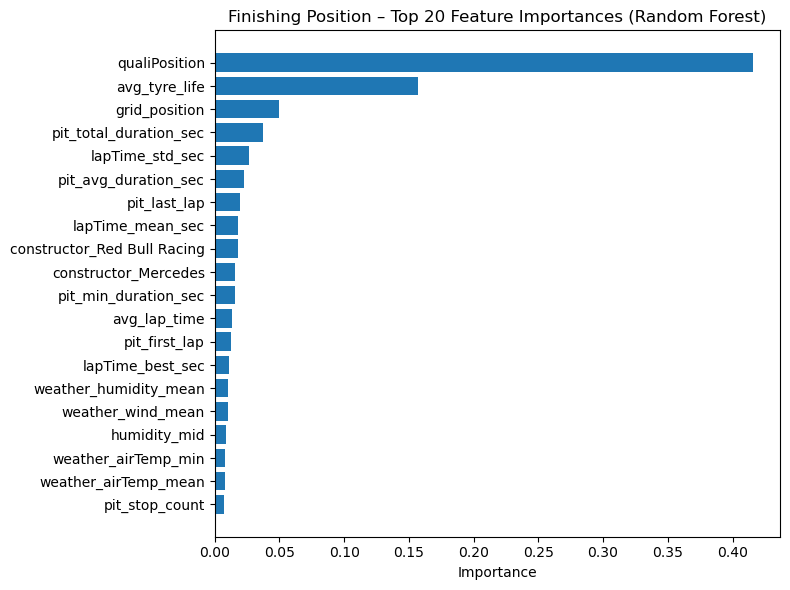

In [18]:
if "Random Forest" in best_pos_name:
    rf_inner = best_pos_model.named_steps["model"]
    ohe_pos = best_pos_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
    num_feats_pos = num_cols_pos
    cat_feats_pos = ohe_pos.get_feature_names_out(cat_cols_pos).tolist()
    all_feats_pos = list(num_feats_pos) + cat_feats_pos

    importances_pos = rf_inner.feature_importances_

    imp_pos_df = pd.DataFrame({
        "feature": all_feats_pos,
        "importance": importances_pos
    }).sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    plt.barh(imp_pos_df["feature"][::-1], imp_pos_df["importance"][::-1])
    plt.title("Finishing Position – Top 20 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

In [19]:
# Refit best model on ALL 2022–2024 data
print(f"Refitting {best_pos_name} on all 2022–2024 races...")
best_pos_model.fit(X_all_pos, y_all_pos)

# Predict finishing position for 2025
X_2025_pos = pred_2025_df[feature_cols_pos].copy()
pred_2025_scores_pos = best_pos_model.predict(X_2025_pos)
pred_2025_df["pred_score_pos"] = pred_2025_scores_pos

# Re-rank within race so each GP has positions 1..N
group_cols = ["year", "race_name"]
pred_2025_ranked_pos = rerank_within_race(
    pred_2025_df,
    pred_col="pred_score_pos",
    group_cols=group_cols,
    ascending=True  # lower score = better
)

Refitting Random Forest on all 2022–2024 races...


In [20]:
pred_2025_ranked_pos["predicted_position"] = pred_2025_ranked_pos["final_predicted_rank"]

# Subset: predictions for Australian GP 2025
aus_pos_preds = pred_2025_ranked_pos[
    (pred_2025_ranked_pos["year"] == 2025) &
    (pred_2025_ranked_pos["race_name"] == "Australian Grand Prix")
].copy()

cols_to_show_pos = [
    "year", "race_name", "driver", "constructor",
    "grid_position", "pred_score_pos", "predicted_position"
]
aus_pos_preds[cols_to_show_pos].sort_values("predicted_position")

,year,race_name,driver,constructor,grid_position,pred_score_pos,predicted_position
0,2025,Australian Grand Prix,NOR,McLaren,1.0,6.0875,1
1,2025,Australian Grand Prix,VER,Red Bull Racing,3.0,8.0675,2
2,2025,Australian Grand Prix,RUS,Mercedes,4.0,8.3575,3
8,2025,Australian Grand Prix,PIA,McLaren,2.0,8.3625,4
11,2025,Australian Grand Prix,TSU,Racing Bulls,5.0,8.8000,5
4,2025,Australian Grand Prix,ALB,Williams,6.0,10.1100,6
3,2025,Australian Grand Prix,ANT,Mercedes,16.0,10.3325,7
7,2025,Australian Grand Prix,LEC,Ferrari,7.0,10.5400,8
9,2025,Australian Grand Prix,HAM,Ferrari,8.0,10.7125,9
10,2025,Australian Grand Prix,GAS,Alpine,9.0,11.0075,10


## Points model

In [21]:
target_col_pts = "points"

drop_cols_pts = [target_col_pts]

# Avoid leakage from finishing_position this time
if "finishing_position" in df_all.columns:
    drop_cols_pts.append("finishing_position")

id_like_cols_pts = [
    "driverId", "raceId", "driver_code", "Driver.code",
    "race_name", "round", "driver", "constructor",
    "flg_podium", "flg_top5"
]
for c in id_like_cols_pts:
    if c in df_all.columns:
        drop_cols_pts.append(c)

X_all_pts = df_all.drop(columns=drop_cols_pts, errors="ignore")
y_all_pts = df_all[target_col_pts]

feature_cols_pts = X_all_pts.columns.tolist()

print("X_all_pts shape:", X_all_pts.shape)
print("y_all_pts shape:", y_all_pts.shape)

X_all_pts shape: (1017, 49)
y_all_pts shape: (1017,)


In [22]:
#  Temporal 80/20 split again
n_pts = len(df_all)
n_train_pts = int(0.8 * n_pts)

X_train_pts = X_all_pts.iloc[:n_train_pts].copy()
y_train_pts = y_all_pts.iloc[:n_train_pts].copy()
X_valid_pts = X_all_pts.iloc[n_train_pts:].copy()
y_valid_pts = y_all_pts.iloc[n_train_pts:].copy()

print("Train (points):", X_train_pts.shape)
print("Valid (points):", X_valid_pts.shape)

Train (points): (813, 49)
Valid (points): (204, 49)


In [23]:
# Build preprocessor + models for points (separate from position)
preprocessor_pts, models_pts, cat_cols_pts, num_cols_pts = build_preprocessor_and_models(X_all_pts)

results_pts = []
for name, model in models_pts.items():
    print(f"\nTraining {name} for POINTS ...")
    model.fit(X_train_pts, y_train_pts)
    y_pred_pts = model.predict(X_valid_pts)
    res = evaluate_regression_model(name, y_valid_pts, y_pred_pts)
    results_pts.append(res)

results_pts_df = pd.DataFrame(results_pts).sort_values("MAE")
results_pts_df

Categorical columns: ['rainfall_mid', 'session_type', 'made_Q2', 'made_Q3', 'eliminated_in_Q1', 'eliminated_in_Q2', 'eliminated_in_Q3', 'pitted', 'multi_stop', 'one_stop']
Numeric columns (first 10): ['air_temp_mid', 'avg_lap_time', 'avg_tyre_life', 'grid_position', 'humidity_mid', 'lapTime_best_sec', 'lapTime_mean_sec', 'lapTime_std_sec', 'laps_count', 'laps_total']

Training Linear Regression for POINTS ...

=== Linear Regression ===
MAE:               3.982
RMSE:              5.390
R²:                0.437
Spearman rho:      0.731
Kendall tau:       0.579
Within 1 position: 0.221
Within 2 positions:0.392
Within 3 positions:0.539

Training Ridge Regression for POINTS ...

=== Ridge Regression ===
MAE:               3.881
RMSE:              5.256
R²:                0.465
Spearman rho:      0.741
Kendall tau:       0.589
Within 1 position: 0.196
Within 2 positions:0.387
Within 3 positions:0.539

Training Lasso Regression for POINTS ...

=== Lasso Regression ===
MAE:               3.883

,Model,MAE,RMSE,R2,Spearman,Kendall,Top1,Top2,Top3
4,XGBoost,3.263386,4.852880,0.543707,0.702355,0.555259,0.294118,0.455882,0.612745
3,Random Forest,3.289694,4.778198,0.557643,0.705900,0.563569,0.245098,0.480392,0.622549
5,Ordinal Ridge,3.411765,5.053634,0.505174,0.744452,0.613511,0.406863,0.529412,0.642157
1,Ridge Regression,3.880670,5.255665,0.464820,0.741210,0.588908,0.196078,0.387255,0.539216
2,Lasso Regression,3.883230,5.258857,0.464169,0.739820,0.586976,0.191176,0.382353,0.539216
0,Linear Regression,3.981725,5.390061,0.437099,0.730799,0.579473,0.220588,0.392157,0.539216


In [26]:
# Pick best points model by RMSE
best_pts_name = results_pts_df.iloc[1]["Model"]
print("Best points model:", best_pts_name)

best_pts_model = models_pts[best_pts_name]


Best points model: XGBoost


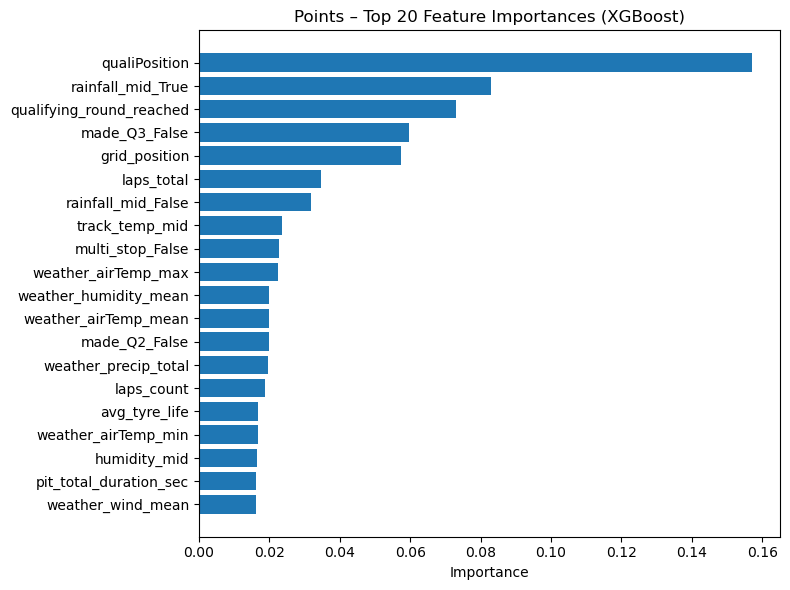

In [28]:
if "Random Forest" in best_pts_name:
    rf_inner_pts = best_pts_model.named_steps["model"]
    ohe_pts = best_pts_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
    num_feats_pts = num_cols_pts
    cat_feats_pts = ohe_pts.get_feature_names_out(cat_cols_pts).tolist()
    all_feats_pts = list(num_feats_pts) + cat_feats_pts

    importances_pts = rf_inner_pts.feature_importances_

    imp_pts_df = pd.DataFrame({
        "feature": all_feats_pts,
        "importance": importances_pts
    }).sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    plt.barh(imp_pts_df["feature"][::-1], imp_pts_df["importance"][::-1])
    plt.title("Points – Top 20 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

elif "XGBoost" in best_pts_name:
    xgb_inner_pts = best_pts_model.named_steps["model"]
    ohe_pts = best_pts_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
    num_feats_pts = num_cols_pts
    cat_feats_pts = ohe_pts.get_feature_names_out(cat_cols_pts).tolist()
    all_feats_pts = list(num_feats_pts) + cat_feats_pts

    importances_pts = xgb_inner_pts.feature_importances_

    imp_pts_df = pd.DataFrame({
        "feature": all_feats_pts,
        "importance": importances_pts
    }).sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    plt.barh(imp_pts_df["feature"][::-1], imp_pts_df["importance"][::-1])
    plt.title("Points – Top 20 Feature Importances (XGBoost)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

In [27]:
print(f"Refitting {best_pts_name} on all 2022–2024 (points)...")
best_pts_model.fit(X_all_pts, y_all_pts)

# Predict points for 2025
X_2025_pts = pred_2025_df[feature_cols_pts].copy()
pred_2025_points = best_pts_model.predict(X_2025_pts)
pred_2025_df["pred_points"] = pred_2025_points

# Subset: predictions for Australian GP 2025
aus_pts_preds = pred_2025_df[
    (pred_2025_df["year"] == 2025) &
    (pred_2025_df["race_name"] == "Australian Grand Prix")
].copy()

cols_to_show_pts = [
    "year", "race_name", "driver", "constructor",
    "grid_position", "pred_points"
]
aus_pts_preds[cols_to_show_pts].sort_values("pred_points", ascending=False)

Refitting XGBoost on all 2022–2024 (points)...


,year,race_name,driver,constructor,grid_position,pred_points
0,2025,Australian Grand Prix,NOR,McLaren,1.0,14.912937
8,2025,Australian Grand Prix,PIA,McLaren,2.0,7.734269
11,2025,Australian Grand Prix,TSU,Racing Bulls,5.0,6.209762
2,2025,Australian Grand Prix,RUS,Mercedes,4.0,6.209198
1,2025,Australian Grand Prix,VER,Red Bull Racing,3.0,6.151050
16,2025,Australian Grand Prix,ALO,Aston Martin,12.0,5.588069
4,2025,Australian Grand Prix,ALB,Williams,6.0,5.074783
14,2025,Australian Grand Prix,LAW,Red Bull Racing,18.0,4.685255
7,2025,Australian Grand Prix,LEC,Ferrari,7.0,4.383631
5,2025,Australian Grand Prix,STR,Aston Martin,13.0,3.924119
